In [2]:
# libraries
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
# import random
import pandas as pd
# import h5py

# import wave
# from scipy.io import wavfile

# import pyprep
# from pyprep.prep_pipeline import PrepPipeline


# # for permutation stats visualization
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mne.viz import plot_compare_evokeds
from scipy import stats
# from mne.stats import spatio_temporal_cluster_1samp_test


# for save and load dict variables
import pickle

# set working directory
work_dir = '/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/'

# General parameters

In [68]:
####################
#### parameters ####
####################

# subjects to exclude
exclude_ppts = [
    '187', # too many bad stims
    '200', # too many bad stims
    '259', # too many bad stims

    '182', # incomplete data
    '135', # incomplete data
    '179', # incomplete cata
]

#### directory ####
input_dir = work_dir + 'data_preprocessed/ica on epochs/5_averaged/'
output_dir = work_dir + 'figures/'

# print(input_dir)
# print(output_dir)

# read in the ERP data:
with open(input_dir + 'all_evokeds.pkl', 'rb') as file:  # Python 3: open(..., 'rb')
    all_evokeds = pickle.load(file)


# get time and channel info from any evoked data
evoked = all_evokeds['100']['ChEn-devi/Eng_001']
time_labels = [str(int(x)) for x in evoked.times*1000]
chan_labels = evoked.info['ch_names']


# create a dictionary for condition key and standard and deviant cells ####
cell_dict = {
    'identityMMN_English_in_Chinese': {'deviant': 'ChEn-devi', 'standard': 'EnCh-stan'},
    'identityMMN_Chinese_in_English': {'deviant': 'EnCh-devi', 'standard': 'ChEn-stan'},
    'identityMMN_English_in_Indian': {'deviant': 'InEn-devi', 'standard': 'EnIn-stan'},
    'identityMMN_Indian_in_English': {'deviant': 'EnIn-devi', 'standard': 'InEn-stan'},
}

# all participants
all_ppts = all_evokeds.keys()

# English participants
with open(work_dir+'data_analysis/English_ppts.txt', 'r') as f:
    english_ppts = [line.strip() for line in f]

# Chinese participants
with open(work_dir+'data_analysis/Chinese_ppts.txt', 'r') as f:
    chinese_ppts = [line.strip() for line in f]
    
# South Asia participants
with open(work_dir+'data_analysis/SouthAsia_ppts.txt', 'r') as f:
    southasia_ppts = [line.strip() for line in f]

# Single-participant, single-condition visualization

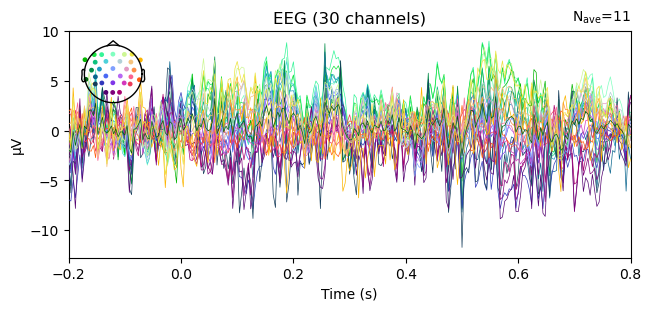

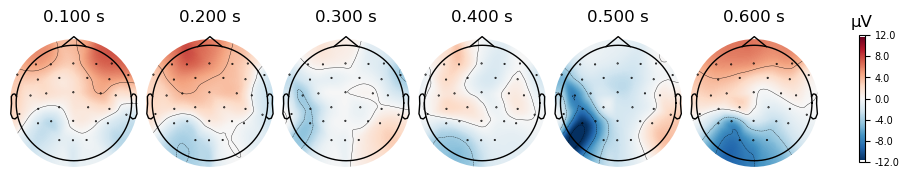

In [8]:
# single-subject, single-condition butterfly
evoked = all_evokeds['100']['ChEn-devi/Eng_001']

# waveform
evoked.plot()

# scalp topography
topo_times = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
evoked.plot_topomap(times=topo_times, colorbar=True)

plt.show()

# Grand-average topographic subplots

## parameters

In [40]:
# choose cell for visualization
cell = 'identityMMN_English_in_Chinese'
# cell = 'identityMMN_Chinese_in_English'
# cell = 'identityMMN_English_in_Indian'
# cell = 'identityMMN_Indian_in_English'


# get subset participants for the cell
subset_ppts = []
# for each subject
for ppt in english_ppts:
    # if it is not in the bad subject list # 
    if (ppt not in exclude_ppts):
        # append that subject to the list
        subset_ppts.append(ppt)

In [41]:
# get legends
legend_standard = 'standard (' + cell.split('_')[1] + ' from ' + cell_dict[cell]['standard'] + ')'
legend_deviant = 'deviant (' + cell.split('_')[1] + ' from ' + cell_dict[cell]['deviant'] + ')'
legend_difference = 'deviants minus standards'

# # colors
# color_devi = "crimson"
# color_stan = "steelblue"
# color_diff = 'black'


##########################
####  ERP Topographical subplot and ROI waveforms ####
##########################

# extract ERPs
erp_standard = []
erp_deviant = []
erp_difference = []
for ppt in subset_ppts:

    # extract conditions
    conditions = all_evokeds[ppt].keys()

    # get standard and deviant keys for pulling out data
    standard_conditions = [ x for x in conditions if x.split('/')[0]==cell_dict[cell]['standard'] ]
    deviant_conditions = [ x for x in conditions if x.split('/')[0]==cell_dict[cell]['deviant'] ]

    # compute temporary standard erp
    tmp_erp_standard = mne.combine_evoked([all_evokeds[ppt][x] for x in standard_conditions],
                                  weights='equal')
    # compute temporary deviant erp
    tmp_erp_deviant = mne.combine_evoked([all_evokeds[ppt][x] for x in deviant_conditions],
                                  weights='equal')
    # compute temporary difference erp
    tmp_erp_difference = mne.combine_evoked([tmp_erp_deviant, tmp_erp_standard],
                                  weights=[1,-1]) # 1 for devi, -1 for stan
    # append temporary data to list
    erp_standard.append(tmp_erp_standard)
    erp_deviant.append(tmp_erp_deviant)
    erp_difference.append(tmp_erp_difference)


# combine data for plotting
evokeds = {}
evokeds[legend_standard] = erp_standard
evokeds[legend_deviant] = erp_deviant
evokeds[legend_difference] = erp_difference

# # set colors
# colors = {}
# colors[legend_stan] = color_stan
# colors[legend_devi] = color_devi
# colors[legend_diff] = color_diff


################################
#### Topographical subplots ####
################################


# figure title for the waveform
waveform_title = cell + ' (n = ' + str(len(subset_ppts)) + ')'

##############################
# waveforms across scalp topo
# NOTE: I don't know how to save these plots using the code
fig = mne.viz.plot_compare_evokeds(
    evokeds,
    axes='topo',
    # picks=pick_chans,
    # combine="mean",
    show_sensors=True,
    # colors=colors,
    title = waveform_title,
    # ylim=dict(eeg=[-5, 5]),
    time_unit="ms",
    show=False,
);
##############################

# Grand-average waves and topos

## parameters

In [69]:
# save the plot?
toggle_save_plot = True
# toggle_save_plot = False

# # colors for each condition?
# color_devi = "crimson"
# color_stan = "steelblue"
# color_diff = 'black'

# times to show in topoplots (in seconds)
times = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

# choose a channel(s) for ERP plot
pick_chans = ["Cz", "Fz", "FC1", "FC2", "C3", "C4", "CP1", "CP2"]

# get channel index
ch_inds = np.isin(chan_labels, pick_chans)


Identifying common channels ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


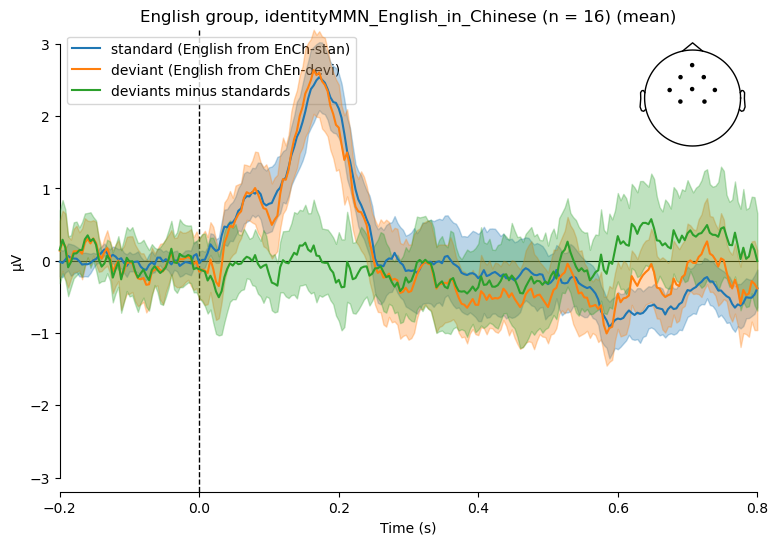

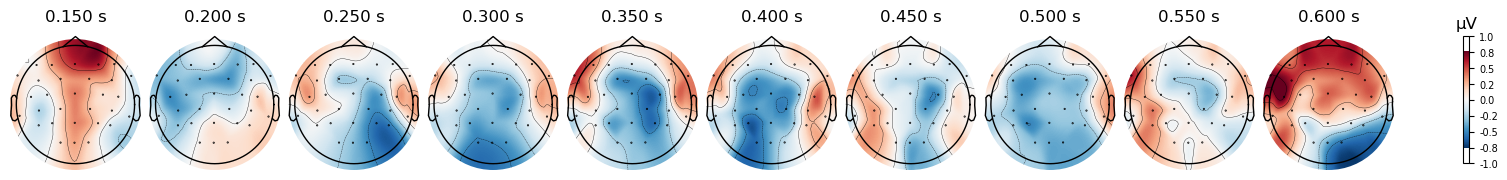

Identifying common channels ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


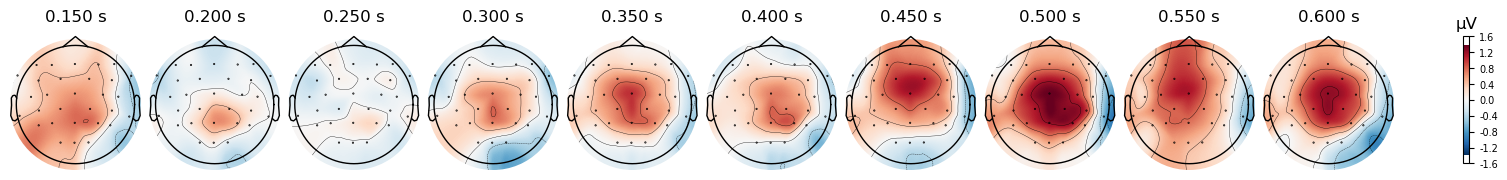

Identifying common channels ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


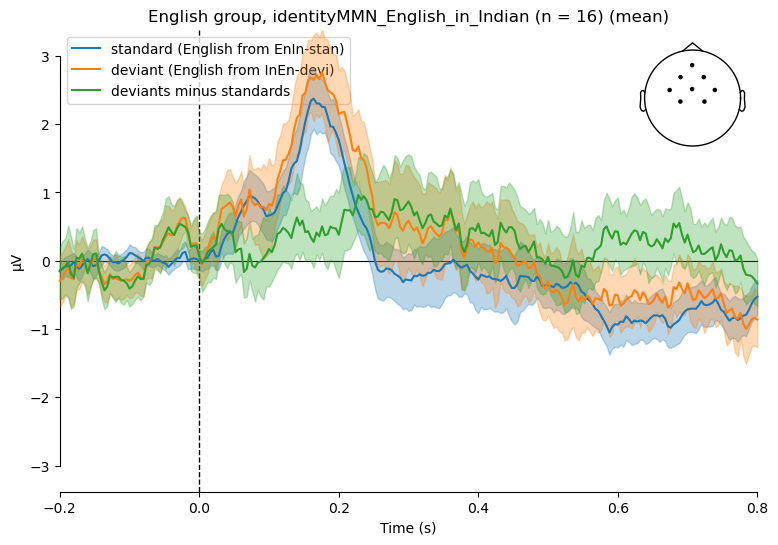

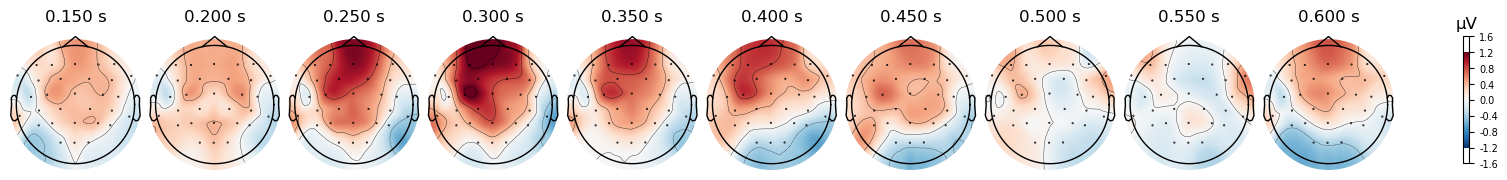

Identifying common channels ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


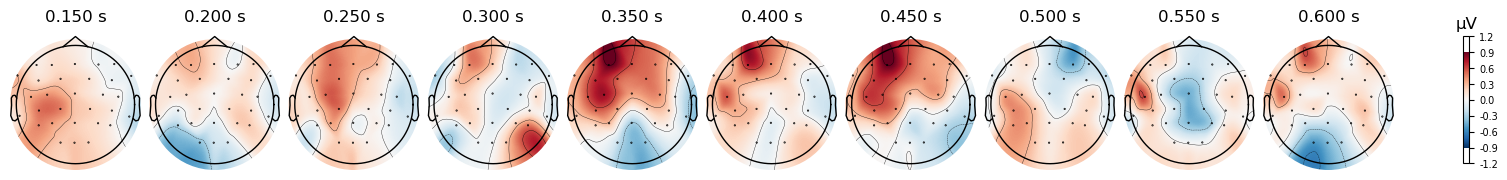

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 3 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Identifying common channels ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


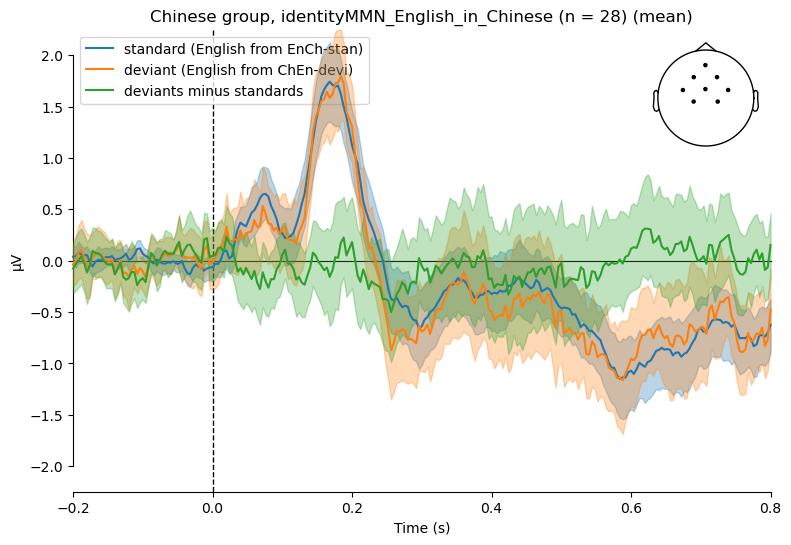

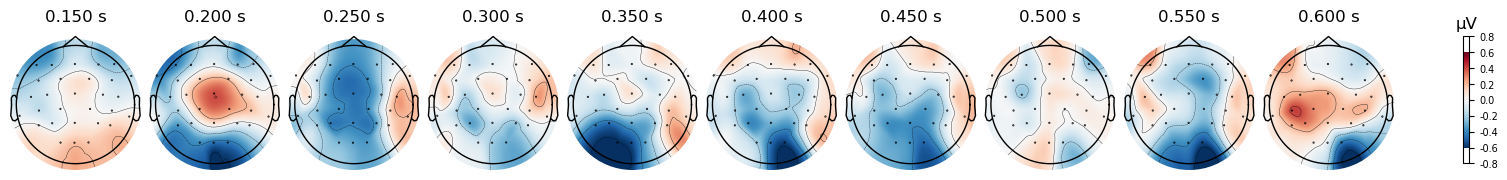

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 3 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Identifying common channels ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


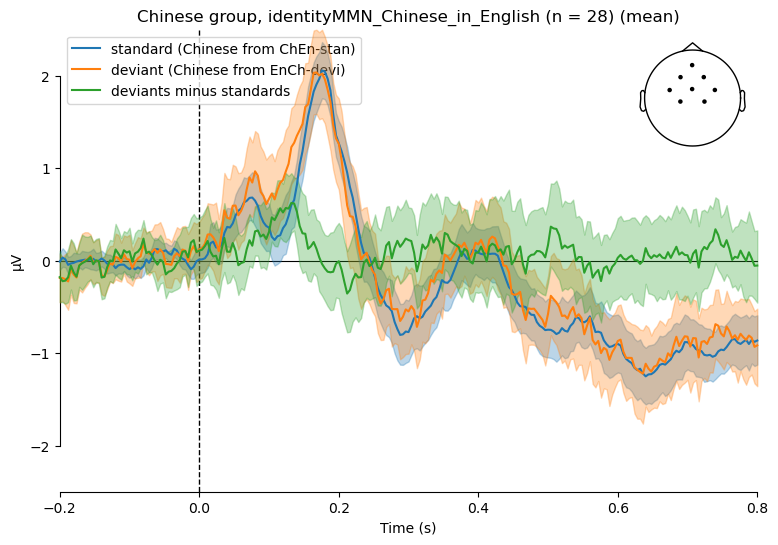

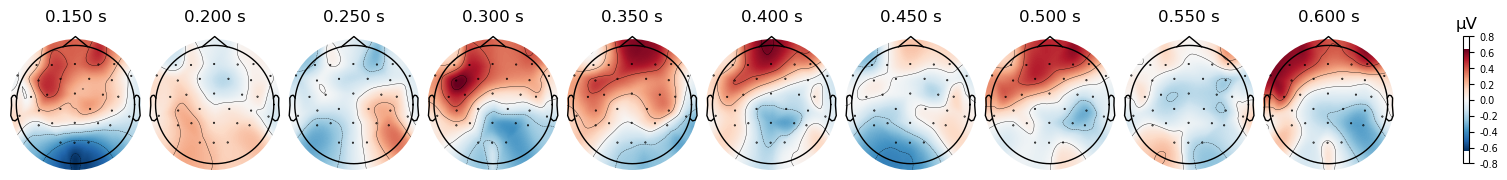

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 3 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Identifying common channels ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


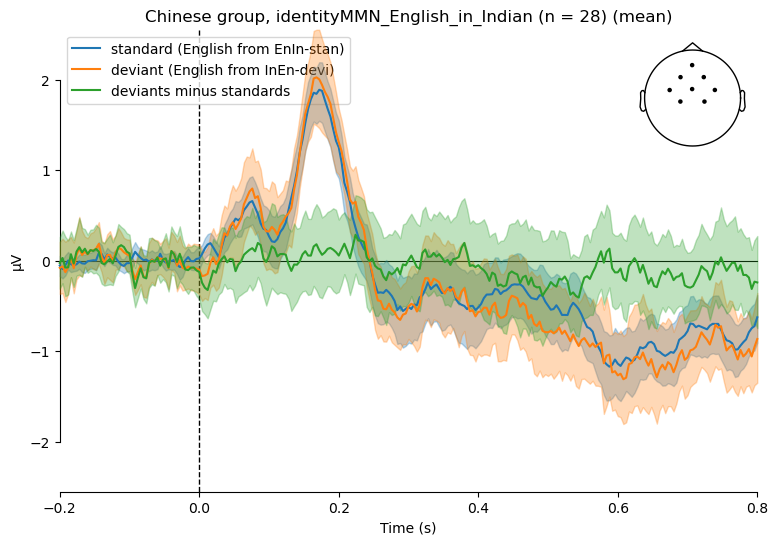

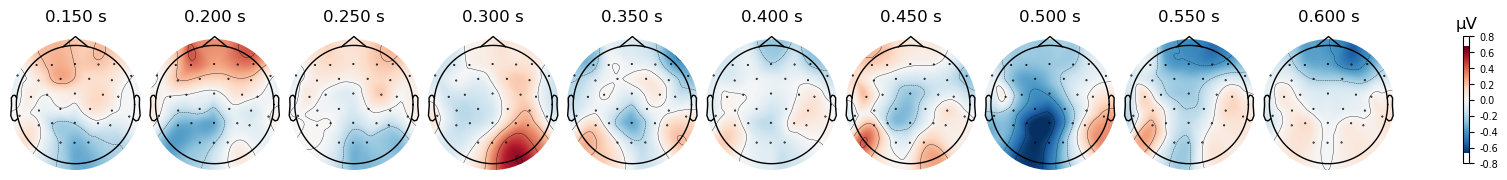

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 3 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Identifying common channels ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


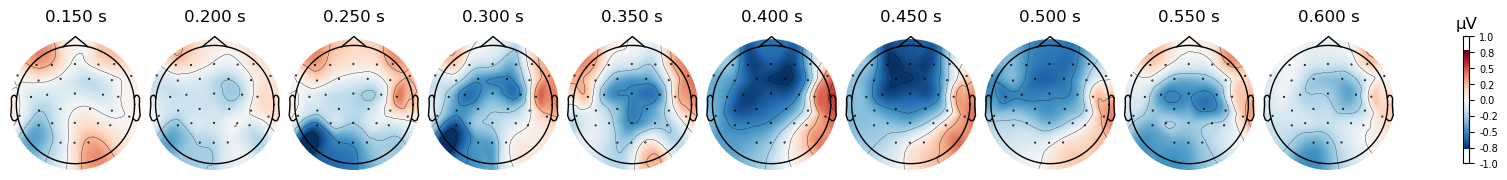

In [70]:
# get the list participants who came this far
all_ppts = list(all_evokeds.keys())

# make participant dictionary
ppt_dict = {
    'English': english_ppts,
    'Chinese': chinese_ppts,
}

# for each group
for ppt_group in ['English', 'Chinese']:
    # get participant list
    subset_ppts = []
    for ppt in all_ppts:
        # if it is not in the bad subject list # 
        if (ppt not in exclude_ppts) and (ppt in ppt_dict[ppt_group]):
            # append that subject to the list
            subset_ppts.append(ppt)

    # for each cell
    for cell in cell_dict.keys():
        
        # get legends
        legend_stan = 'standard (' + cell.split('_')[1] + ' from ' + cell_dict[cell]['standard'] + ')'
        legend_devi = 'deviant (' + cell.split('_')[1] + ' from ' + cell_dict[cell]['deviant'] + ')'
        legend_diff = 'deviants minus standards'
        
        # extract ERPs
    
        # initialize list
        erp_stan = []
        erp_devi = []
        erp_diff = []
    
        # for each subject
        for ppt in subset_ppts:

            # extract conditions
            conditions = all_evokeds[ppt].keys()
        
            # get standard and deviant keys for pulling out data
            stan_conditions = [ x for x in conditions if x.split('/')[0]==cell_dict[cell]['standard'] ]
            devi_conditions = [ x for x in conditions if x.split('/')[0]==cell_dict[cell]['deviant'] ]
        
            # compute temporary standard erp
            tmp_stan = mne.combine_evoked([all_evokeds[ppt][x] for x in stan_conditions],
                                          weights='equal')
            # compute temporary deviant erp
            tmp_devi = mne.combine_evoked([all_evokeds[ppt][x] for x in devi_conditions],
                                          weights='equal')
            # compute temporary difference erp
            tmp_diff = mne.combine_evoked([tmp_devi, tmp_stan],
                                          weights=[1,-1]) # 1 for devi, -1 for stan
            # append temporary data to list
            erp_stan.append(tmp_stan)
            erp_devi.append(tmp_devi)
            erp_diff.append(tmp_diff)
    
        # compute grand average of difference waves
        grand_avg_diff = mne.grand_average(erp_diff)
        
        
        # combine data for plotting
        evokeds = {}
        evokeds[legend_stan] = erp_stan
        evokeds[legend_devi] = erp_devi
        evokeds[legend_diff] = erp_diff
        
        # # set colors
        # colors = {}
        # colors[legend_stan] = color_stan
        # colors[legend_devi] = color_devi
        # colors[legend_diff] = color_diff
        
        
        # ################################
        # #### plot gav waveform ####
        # ################################
        
        # figure title for the waveform
        waveform_title = ppt_group + ' group, ' + cell + ' (n = ' + str(len(subset_ppts)) + ')'

        wave, ax = plt.subplots(1, 1, figsize=(9, 6))
        
        mne.viz.plot_compare_evokeds(
            evokeds,
            axes=ax,
            picks=pick_chans,
            combine="mean",
            show_sensors=True,
            # colors=colors,
            title = waveform_title,
            # ylim=dict(eeg=[-5, 5]),
            time_unit="s",
            show=False
        )
        # save fig
        if toggle_save_plot:
            wave.savefig(output_dir + '/wave_' + ppt_group + '_' + cell +'.png')
        
        
        #### topomap of difference wave (deviants minus standards) ####
        
        #### plotting topo ####
        topo = grand_avg_diff.plot_topomap(
            ch_type="eeg", 
            times=times, 
            colorbar=True,
            # vlim = (-2,2)
        )
        
        # save fig
        if toggle_save_plot:
            topo.savefig(output_dir + '/topo_' + ppt_group + '_' + cell +'.png')
        
        
        
        # ##################################################################################
        # # For each subject extract the windows average centering the negative peak latency
        # ##################################################################################
        
    
        # # for each subject 
        # for subj in subset_subs:
        #     # compute temporary standard erp
        #     tmp_stan = all_evokeds[subj][key_stan]
        #     # compute temporary deviant erp
        #     tmp_devi = all_evokeds[subj][key_devi]
        #     # compute temporary difference erp
        #     tmp_diff = mne.combine_evoked(
        #         [tmp_devi, tmp_stan],
        #         weights=[1,-1] # 1 for devi, -1 for stan
        #     )
    
            # ##################################
            # #### plot individual waveform ####
    
            # # combine data for plotting
            # evokeds = {}
            # evokeds[legend_stan] = tmp_stan
            # evokeds[legend_devi] = tmp_devi
            # evokeds[legend_diff] = tmp_diff
            
            # # set colors
            # colors = {}
            # colors[legend_stan] = color_stan
            # colors[legend_devi] = color_devi
            # colors[legend_diff] = color_diff
            
            # # figure title for the waveform
            # waveform_title = subj + " " + cell_i
            
            # # figure axes
            # indi_fig, indi_ax = plt.subplots(
            #     1, 1, 
            #     figsize=(7, 5),
            #     layout="constrained"
            # )
            # mne.viz.plot_compare_evokeds(
            #     evokeds,
            #     axes=indi_ax,
            #     picks=pick_chans,
            #     combine="mean",
            #     show_sensors=True,
            #     colors=colors,
            #     title = waveform_title,
            #     # ylim=dict(eeg=[-5, 5]),
            #     time_unit="ms",
            #     show=False,
            # )
            # plt.close()
            
            # # save fig
            # if toggle_save_plot:
            #     indi_fig.savefig(output_dir_individual + '/' + subj + "_" + cell_i +'.png')
            # ##############################

In [ ]:
#### combine figures into one ####
image_files = {
    'f0': [
        'wave_identityMMN_dorsal_highF0',
        'wave_identityMMN_dorsal_lowF0',
        'wave_identityMMN_glottal_highF0',
        'wave_identityMMN_glottal_lowF0',
        'wave_withinBlockMMN_dorsal_highF0',
        'wave_withinBlockMMN_dorsal_lowF0',
        'wave_withinBlockMMN_glottal_highF0',
        'wave_withinBlockMMN_glottal_lowF0',
    ],
    'vot': [
        'wave_identityMMN_dorsal_longVOT',
        'wave_identityMMN_dorsal_shortVOT',
        'wave_identityMMN_glottal_longVOT',
        'wave_identityMMN_glottal_shortVOT',
        'wave_withinBlockMMN_dorsal_longVOT',
        'wave_withinBlockMMN_dorsal_shortVOT',
        'wave_withinBlockMMN_glottal_longVOT',
        'wave_withinBlockMMN_glottal_shortVOT',        
    ]
}

# combine figures
for group in ['f0', 'vot']:
    # initialize
    fig, axes = plt.subplots(4, 2, figsize=(15, 20))
    axes = axes.flatten()
    # read in image and combine
    for ax, file_name in zip(axes, image_files[group]):
        img = mpimg.imread(output_dir + '/' + file_name + '.png')
        ax.imshow(img)
        ax.axis('off')  # Hide axes
    # save
    plt.tight_layout()
    plt.savefig(output_dir + '/wave_combined_' + group + '.png', dpi=300)
    plt.close()
########################################

## Cluter-based permutation analysis of MMN

In [10]:
############################
#### Parameters ############
############################

# which list do you want to look at?
# all subjects
# subj_list = list(all_evokeds[list(all_evokeds.keys())[0]].keys())

# English subjects
with open("input/English_subj_list.txt", "r") as file:
    english_subj_list = [line.strip() for line in file]

# Chinese subjects
with open("input/Chinese_subj_list.txt", "r") as file:
    chinese_subj_list = [line.strip() for line in file]
    
# South Asia
with open("input/SouthAsia_subj_list.txt", "r") as file:
    southasia_subj_list = [line.strip() for line in file]

# which subject list to use? What do you want to call this group? (It shows in title)
# subj_list = english_subj_list; subj_group = 'EN speakers'
# subj_list = chinese_subj_list; subj_group = 'CH speakers'
subj_list = english_subj_list + chinese_subj_list; subj_group = 'EN+CH speakers'


#### exclude bad subjects ####

# read in file for bad subjects
with open(input_dir + '../bad_subjects.txt', 'r') as file:
    bad_subs = [line.strip() for line in file]

# get the list of all subjects that came this far
all_subs = list(all_evokeds[list(all_evokeds.keys())[0]].keys())

subset_subs = []
# for each subject in the subject list
for i_subj in subj_list:
    # if it is not in the bad subject list
    if (i_subj not in bad_subs) and (i_subj in all_subs):
        # append that subject to the list
        subset_subs.append(i_subj)


#### stim keys ####
# choose standard and deviant stimuli you are interested; choose from: 
# ['ChEn-devi', 'ChEn-stan', 'EnCh-devi', 'EnCh-stan', 'EnIn-devi', 'EnIn-stan', 'InEn-devi', 'InEn-stan']
# e.g., if you are interested in the iMMN to English deviant among Chinese standards,
# you should compare 'ChEn-devi' to 'EnCh-stan'.

#### for comparing one block ####

# devi_key = 'ChEn-devi'
# stan_key = 'EnCh-stan'
        
# # extract data
# devi_dict = {}
# stan_dict = {}

# # add subject data
# for i_subj in subset_subs:
#     # compute the difference wave (deviants - standards)
#     devi_dict[i_subj] = all_evokeds[devi_key][i_subj]
#     stan_dict[i_subj] = all_evokeds[stan_key][i_subj]


# # #### for comparing multiple blocks ####

devi_keys = ['ChEn-devi', 'EnCh-devi']
stan_keys = ['EnCh-stan', 'ChEn-stan']

devi_dict = {}
stan_dict = {}
# add subject data
for i_subj in subset_subs:
    # compute the difference wave (deviants - standards)
    devi_dict[i_subj] = mne.combine_evoked([all_evokeds[devi_keys[0]][i_subj], all_evokeds[devi_keys[1]][i_subj]], 
                                           weights=[1/2, 1/2])
    stan_dict[i_subj] = mne.combine_evoked([all_evokeds[stan_keys[0]][i_subj], all_evokeds[stan_keys[1]][i_subj]],
                                           weights=[1/2, 1/2])


    
# initialize a dictionary for computing MMN
erp_diff = {}

# add subject data
for i_subj in subset_subs:
    # compute the difference wave (deviants - standards)
    erp_diff[i_subj] = mne.combine_evoked(
        [devi_dict[i_subj], stan_dict[i_subj]],
        weights=[1,-1]
    )



###################################
#### Find the adjacency matrix ####
###################################

# get epoch info
epoch_info = list(list(all_evokeds.values())[0].values())[0]

chan_adj, chan_names = mne.channels.find_ch_adjacency(epoch_info.info, 'eeg')

# # visualize
# mne.viz.plot_ch_adjacency(cond_1['106'].info, chan_adj, chan_names)
# plt.show()


#####################
#### compute MMN ####
#####################


# extract data for stats
erp_diff_data = np.stack([erp_diff[k].get_data() for k in erp_diff.keys()], axis=0)

# # check the shape
# print(erp_diff_data.shape)


# reshape the data for stats analysis
X = np.transpose(erp_diff_data, [0, 2, 1]) # output: subject x time x channel

# print(X.shape)


###################################
#### cluster-based permutation ####
###################################

# Here we set a cluster forming threshold based on a p-value for
# the cluster based permutation test.
# We use a two-tailed threshold, the "1 - p_threshold" is needed
# because for two-tailed tests we must specify a positive threshold.
n_subjects = X.shape[0]
p_threshold = 0.05
df = n_subjects - 1  # degrees of freedom for the test
t_threshold = stats.distributions.t.ppf(1 - p_threshold/2, df=df)


# Now let's actually do the clustering.
T_obs, clusters, cluster_p_values, H0 = spatio_temporal_cluster_1samp_test(
    X,
    adjacency=chan_adj,
    n_jobs=None,
    threshold=-t_threshold,
    # threshold=None,
    buffer_size=None,
    verbose=True,
    tail = -1, # one-tail test
    seed = 42 # set random seed

)



#########################
#### select clusters ####
#########################

# Select the clusters that are statistically significant at p < 0.05
p_accept = 0.05
good_clusters_idx = np.where(cluster_p_values < p_accept)[0]

print(good_clusters_idx)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 32
stat_fun(H1): min=-3.9603969672089017 max=3.1504080772836818
Running initial clustering …
Found 30 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

[13]


Identifying common channels ...
combining channels using "mean"
combining channels using "mean"


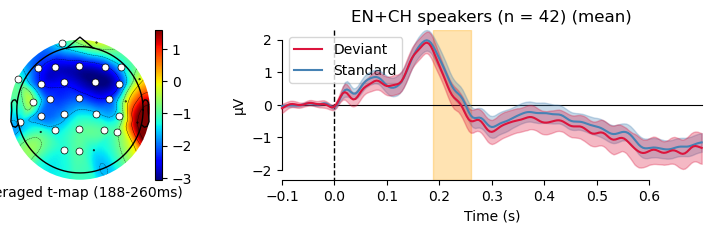

In [12]:
#######################
#### visualization ####
#######################

#### parameter ####
toggle_save_plot = False

# pick_chans = ['Cz']

# title
permutation_wave_title = subj_group + ' (n = ' + str(len(subset_subs)) + ')'

# What legend do you want to give to each type of stimuli? It shows in plots
legend_devi = 'Deviant'
legend_stan = 'Standard'




#### prepare data for waveform plotting ####
stan_data = [stan_dict[k] for k in stan_dict.keys()]
devi_data = [devi_dict[k] for k in devi_dict.keys()]

# organize data for plotting
evokeds = {
    legend_stan: stan_data,
    legend_devi: devi_data,
}


#### prepare data for topo plotting ####

# create a list of grand average differences
erp_diff_list = list(erp_diff.values())

grand_avg_diff = mne.grand_average(erp_diff_list)


## visualize clusters

if len(good_clusters_idx) > 0:
    
    # configure variables for visualization
    colors = {legend_devi: "crimson", legend_stan: "steelblue"}
    # linestyles = {"ChEn_d": "-", "ChEn_s": "--"}

    # loop over clusters
    for i_clu in range(len(good_clusters_idx)):
        # unpack cluster information, get unique indices
        time_inds, space_inds = np.squeeze(clusters[good_clusters_idx[i_clu]])

        # get channel indices
        ch_inds = np.unique(space_inds)
        # convert it to panda dataframe and save as .txt
        df = pd.DataFrame(ch_inds+1)
        df.to_csv('input/stats_channel_index_' + subj_group + '_All_blocks_cluster' + str(i_clu) + '.txt', header=False, index=False)
        # df.to_csv('input/stats_channel_index_' + subj_group + '_' + devi_key + '_minus_' + stan_key + '_cluster' + str(i_clu) + '.txt', header=False, index=False)
        
        # get time indices
        time_inds = np.unique(time_inds)
        # convert it to panda dataframe and save as .txt
        df = pd.DataFrame(time_inds+1)
        df.to_csv('input/stats_time_index_' + subj_group + '_All_blocks_cluster' + str(i_clu) + '.txt', header=False, index=False)
        # df.to_csv('input/stats_time_index_' + subj_group + '_' + devi_key + '_minus_' + stan_key + '_cluster' + str(i_clu) + '.txt', header=False, index=False)
        
        
        # get topography for F stat
        t_map = T_obs[time_inds, ...].mean(axis=0)

        # get signals at the sensors contributing to the cluster
        sig_times = epoch_info.times[time_inds]

        # create spatial mask
        mask = np.zeros((t_map.shape[0], 148), dtype=bool) # the number is obtained based on the error message, I don't know how to decide this number.
        mask[ch_inds, :] = True

        # initialize figure
        fig, ax_topo = plt.subplots(1, 1, figsize=(7, 5), layout="constrained")

        # plot topos of average test statistic and mark significant sensors
        t_evoked = mne.EvokedArray(t_map[:, np.newaxis]/1e6, epoch_info.info, tmin=0)
        t_evoked.plot_topomap(
            times=0,
            mask=mask,
            axes=ax_topo,
            cmap="jet",
            vlim=(np.min, np.max),
            show=False,
            colorbar=False,
            mask_params=dict(markersize=10),
        )
        image = ax_topo.images[0]

        # remove the title that would otherwise say "0.000 s"
        ax_topo.set_title("")

        # create additional axes (for ERF and colorbar)
        divider = make_axes_locatable(ax_topo)

        # add axes for colorbar
        ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(image, cax=ax_colorbar)
        ax_topo.set_xlabel(
            "Averaged t-map ({:}-{:}ms)".format(int(sig_times[0]*1000), int(sig_times[-1]*1000))
        )

        # add new axis for time courses and plot time courses
        ax_signals = divider.append_axes("right", size="300%", pad=1.2)

        # plot waveforms
        plot_compare_evokeds(
            evokeds,
            title=permutation_wave_title,
            picks=ch_inds,
            axes=ax_signals,
            colors=colors,
            # linestyles=linestyles,
            show=False,
            split_legend=True,
            truncate_yaxis="auto",
            combine="mean",
        )
        

        # plot temporal cluster extent
        ymin, ymax = ax_signals.get_ylim()
        ax_signals.fill_betweenx(
            (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.3
        )

        # save
        if toggle_save_plot:
            fig.savefig(output_dir + 'permutation_' + subj_group + '_cluster' + str(i_clu) + '.png')



        # #### plotting topo of voltage ####
        # # figure axes
        # fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        # ax_topo = fig.add_axes([0.9, 0.1, 0.05, 0.7])

        # t_evoked = mne.EvokedArray(t_map[:, np.newaxis], epoch_info.info, tmin=0)
        # t_evoked.plot_topomap(
        #     times=0,
        #     mask=mask,
        #     mask_params=dict(markersize=6 ),
        #     axes=[ax, ax_topo],
        #     # cmap="jet",
        #     vlim=(np.min, np.max),
        #     show=False,
        #     colorbar=True,
        # )
        
        # ax_topo.set_title("Your Title", fontsize=14)
        # ax.set_title('{:}-{:}ms'.format(int(sig_times[0]*1000), int(sig_times[-1]*1000)), fontsize=10)

    
        # save fig
        # if toggle_save_plot:
        #     fig.savefig(output_dir + 'permutation_voltage_topo_' + subj_group + '_' + 'cluster' + str(i_clu) + '.png', bbox_inches='tight')
    
    # plt.show()

## Visualization, waveform + t-map, for poster

Identifying common channels ...
combining channels using "mean"
combining channels using "mean"


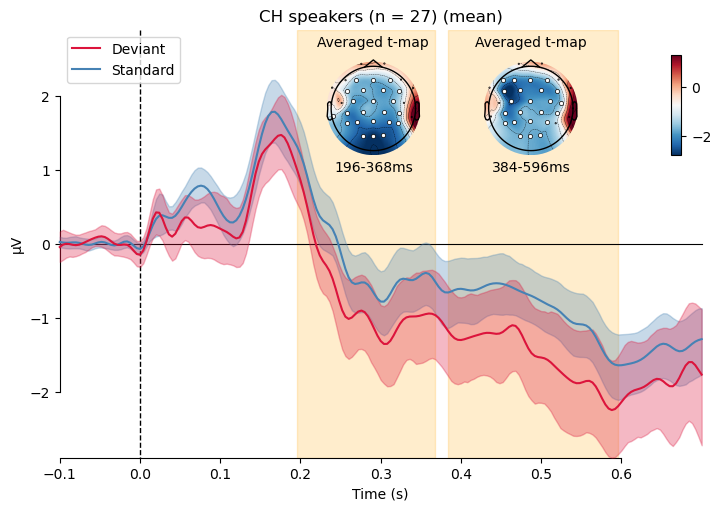

In [89]:
#######################
#### visualization, waveform + t-map, for poster ####
#######################

#### parameter ####
toggle_save_plot = True

# pick_chans = ['Cz']

# title
permutation_wave_title = subj_group + ' (n = ' + str(len(subset_subs)) + ')'

# What legend do you want to give to each type of stimuli? It shows in plots
legend_devi = 'Deviant'
legend_stan = 'Standard'




#### prepare data for waveform plotting ####
stan_data = [stan_dict[k] for k in stan_dict.keys()]
devi_data = [devi_dict[k] for k in devi_dict.keys()]

# organize data for plotting
evokeds = {
    legend_stan: stan_data,
    legend_devi: devi_data,
}


#### prepare data for topo plotting ####

# create a list of grand average differences
erp_diff_list = list(erp_diff.values())

grand_avg_diff = mne.grand_average(erp_diff_list)


## visualize clusters

if len(good_clusters_idx) > 0:
    
    # configure variables for visualization
    colors = {legend_devi: "crimson", legend_stan: "steelblue"}
    # linestyles = {"ChEn_d": "-", "ChEn_s": "--"}

    # loop over clusters
    for i_clu in range(len(good_clusters_idx)):
        # unpack cluster information, get unique indices
        time_inds, space_inds = np.squeeze(clusters[good_clusters_idx[i_clu]])

        # get channel indices
        ch_inds = np.unique(space_inds)
        # convert it to panda dataframe and save as .txt
        # df = pd.DataFrame(ch_inds+1)
        # df.to_csv('input/stats_channel_index_' + subj_group + '_All_blocks_cluster' + str(i_clu) + '.txt', header=False, index=False)
        # df.to_csv('input/stats_channel_index_' + subj_group + '_' + devi_key + '_minus_' + stan_key + '_cluster' + str(i_clu) + '.txt', header=False, index=False)
        
        # get time indices
        time_inds = np.unique(time_inds)
        # # convert it to panda dataframe and save as .txt
        # df = pd.DataFrame(time_inds+1)
        # # df.to_csv('input/stats_time_index_' + subj_group + '_All_blocks_cluster' + str(i_clu) + '.txt', header=False, index=False)
        # df.to_csv('input/stats_time_index_' + subj_group + '_' + devi_key + '_minus_' + stan_key + '_cluster' + str(i_clu) + '.txt', header=False, index=False)
        
        
        # get topography for F stat
        t_map = T_obs[time_inds, ...].mean(axis=0)/1e6

        # get signals at the sensors contributing to the cluster
        sig_times = epoch_info.times[time_inds]

        # create spatial mask
        mask = np.zeros((t_map.shape[0], 1), dtype=bool) # the number is obtained based on the error message, I don't know how to decide this number.
        mask[ch_inds, :] = True

        # initialize figure
        if i_clu==0:
            fig, ax_wave = plt.subplots(1, 1, figsize=(7, 5), layout="constrained")
            
            # plot waveforms
            plot_compare_evokeds(
                evokeds,
                title=permutation_wave_title,
                picks=ch_inds,
                axes=ax_wave,
                colors=colors,
                # linestyles=linestyles,
                show=False,
                split_legend=True,
                truncate_yaxis="auto",
                combine="mean",
            )
        

            # plot temporal cluster extent
            ymin, ymax = ax_wave.get_ylim()
            ax_wave.fill_betweenx(
                (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.2
            )

        # for the 2nd cluster of CH group
        else:
            ax_wave.fill_betweenx(
                (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.2
            )


        #### plotting topo of tmap ####

        # position for tmap topo
        if subj_group == 'CH speakers':
            if i_clu==0:
                ax_topo = fig.add_axes([0.425, 0.7, 0.2, 0.2]) # topo position for CH speaker cluster 1
                # Position for the colorbar
                cbar_ax = fig.add_axes([0.95, 0.7, 0.015, 0.2])
            else:
                ax_topo = fig.add_axes([0.65, 0.7, 0.2, 0.2])
        else:
            ax_topo = fig.add_axes([0.57, 0.7, 0.2, 0.2]) # topo position for EN speaker
            # Position for the colorbar
            cbar_ax = fig.add_axes([0.95, 0.7, 0.015, 0.2])



        # plot topos of average test statistic and mark significant sensors
        t_evoked = mne.EvokedArray(t_map[:, np.newaxis], epoch_info.info, tmin=0)
        t_evoked.plot_topomap(
            times=0,
            mask=mask,
            axes=ax_topo,
            # cmap="jet",
            vlim=(np.min, np.max),
            show=False,
            colorbar=False,
            mask_params=dict(markersize=6),
        )

        # ax_topo.set_title("Your Title", fontsize=14)
        ax_topo.set_title('Averaged t-map', fontsize=10)

        ax_topo.set_xlabel(
            "{:}-{:}ms".format(int(sig_times[0]*1000), int(sig_times[-1]*1000))
        )
        
        # add colorbar
        if i_clu == 0:
            image = ax_topo.images[0]
            plt.colorbar(image, cax=cbar_ax)
            cbar_ax.tick_params(labelsize=10)
            cbar_ax.yaxis.get_offset_text().set_fontsize(10)

    

        
        # save fig
        if toggle_save_plot:
            fig.savefig(output_dir + 'permutation_waveform+t-map_' + subj_group + '_' + devi_key + '_minus_' + stan_key + '.png', bbox_inches='tight')
    
    

## Time-frequency analysis

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).


/opt/anaconda3/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


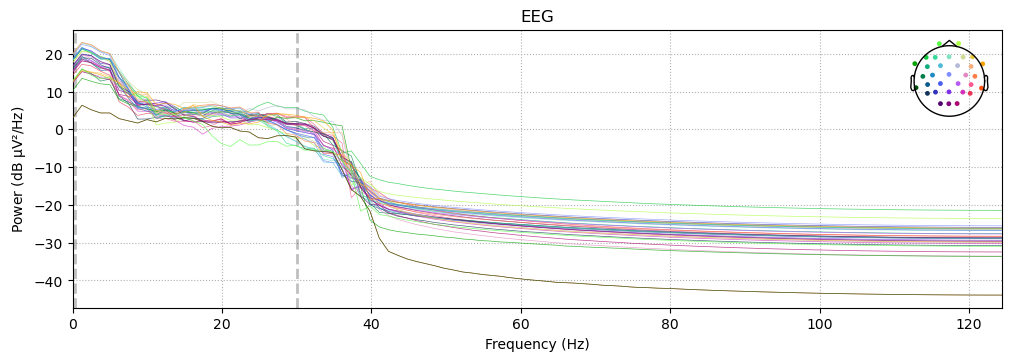

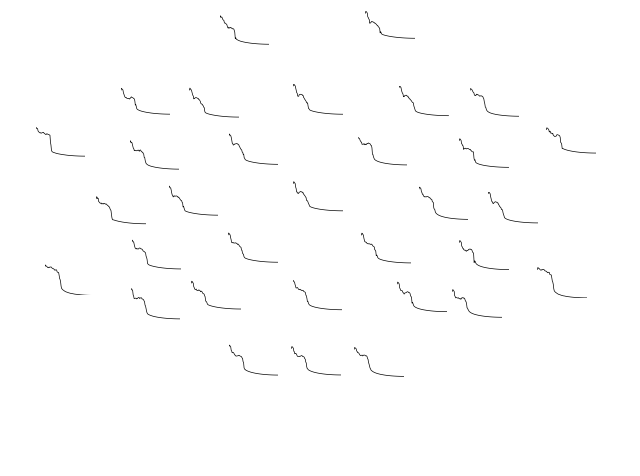

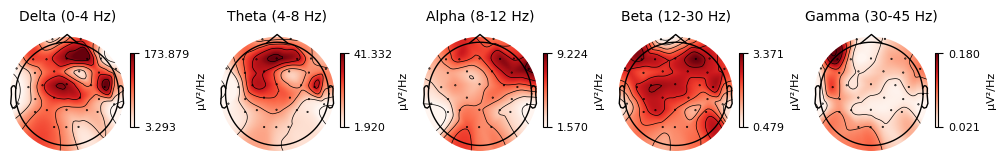

In [80]:
# test_data.compute_psd()
test_spectrum = test_data.compute_psd(
    method="multitaper",
    # tmin=0.3, tmax=0.5, 
    # fmin=5, fmax=30, 
    picks="eeg")

test_spectrum.plot(
    picks = "data",
    exclude = "bads",
    amplitude = False
)

test_spectrum.plot_topo(
    color = "k",
    fig_facecolor = "w",
    axis_facecolor = "w"
)


test_spectrum.plot_topomap(ch_type="eeg", agg_fun=np.median)

plt.show()

In [86]:
#### get ERP ####

# read in data
epochs = mne.read_epochs(input_dir + '../Yas_100_epoc.fif', preload = True)


Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/2_preprocessed/3_ica_all_thres0/4_filtered/5_epoched/6_erp/../Yas_100_epoc.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
2200 matching events found
No baseline correction applied
0 projection items activated


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_12419/2390430247.py:4: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/2_preprocessed/3_ica_all_thres0/4_filtered/5_epoched/6_erp/../Yas_100_epoc.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(input_dir + '../Yas_100_epoc.fif', preload = True)


Effective window size : 0.804 (s)
Plotting power spectral density (dB=True).
Averaging across epochs...


/opt/anaconda3/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


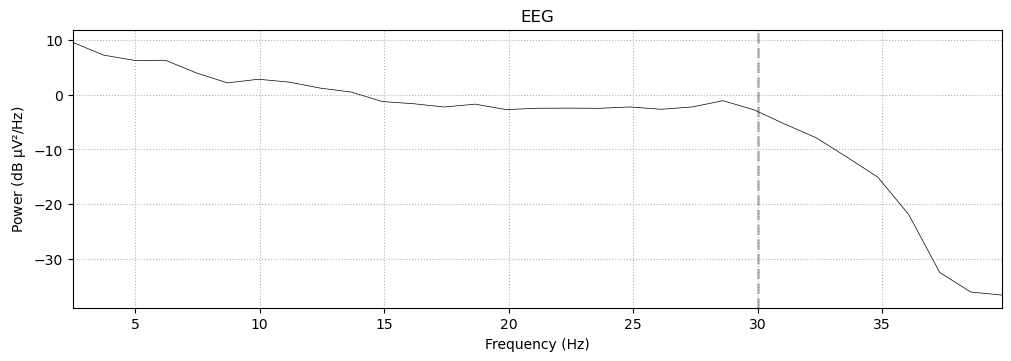

In [160]:
# PSD averaged across all channel types and all epochs
epo_spectrum = epochs['ChEn-devi'].compute_psd(
    fmin=2.0, fmax=40.0,
    method="welch",
    picks=['Cz']
)


epo_spectrum.plot(
    average=True,
    amplitude=False,
    # picks="data",
    # exclude="bads"
)

# # distributions of the PSD, averaged across epochs and frequency bands
# epo_spectrum.plot_topomap(ch_type="eeg", normalize=False, contours=0)
# plt.show()

# psds, freqs = epo_spectrum.get_data(return_freqs=True)
# print(f"\nPSDs shape: {psds.shape}, freqs shape: {freqs.shape}")
# epo_spectrum

plt.show()

In [108]:
# Estimate PSDs based on "mean" and "median" averaging for comparison.
kwargs = dict(fmin=2, fmax=40, n_jobs=None)
psds_welch_mean, freqs_mean = epochs.compute_psd(
    "welch", average="mean", **kwargs
).get_data(return_freqs=True)
psds_welch_median, freqs_median = epochs.compute_psd(
    "welch", average="median", **kwargs
).get_data(return_freqs=True)

# Convert power to dB scale.
psds_welch_mean = 10 * np.log10(psds_welch_mean)
psds_welch_median = 10 * np.log10(psds_welch_median)

# We will only plot the PSD for a single sensor in the first epoch.
ch_name = "Cz"
ch_idx = epochs.info["ch_names"].index(ch_name)
epo_idx = 0

_, ax = plt.subplots()
ax.plot(
    freqs_mean,
    psds_welch_mean[epo_idx, ch_idx, :],
    color="k",
    ls="-",
    label="mean of segments",
)
ax.plot(
    freqs_median,
    psds_welch_median[epo_idx, ch_idx, :],
    color="k",
    ls="--",
    label="median of segments",
)

ax.set(
    title=f"Welch PSD ({ch_name}, Epoch {epo_idx})",
    xlabel="Frequency (Hz)",
    ylabel="Power Spectral Density (dB)",
)
ax.legend(loc="upper right")

Effective window size : 0.804 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Effective window size : 0.804 (s)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.9s finished
